2019-1H-Termproject Proposal





0) 주제: '유튜브 컨텐츠'를 활용한 상품의 감정 추이 분석.  <br>

# 1) 주제 선정 이유<br>
세계 최대 미디어 시장 유튜브에서 수많은 컨텐츠들이 소비된다. 기업에서도 유튜브를 이용한 홍보를 자주 활용한다. 1인 방송 이외에도 '상품의 리뷰' 컨텐츠도 많이 업로드된다.
    기존의 유튜브 분석은 단순히 구독자 수 추이를 활용한 마케팅 목적이 주를 이루었다.
    하지만 유튜브의 타이틀과 댓글, 좋아요 수 등을 이용하여 시간대별로 감정 추이를 분석하면, 대중의 상품에 대한 이미지를 분석할 수 있을 것이다. 이를 활용하여 적절한 광고 전략과, 트렌드 분석에 활용 할 수 있을 것이다.
    실제로 갤럭시 폴드도 결함 논란이 일어나기 전과, 후의 유튜브 타이틀과 댓글 분위기에 차이가 있음을 알 수 있다.
    위 프로젝트에서는 특히 제품과 인물에 대한 감정 추이를 유튜브를 활용하여 분석할 것이다.
    
    
# 2) 가설 정의
    유튜브의 컨텐츠를 이용하여 시간대별로 감정 추이를 분석하면, 대중의 상품에 대한 이미지와 주요 사건이 미친 영향을 분석할 수 있을 것이다.
# 3) 인터넷을 통한 데이터 획득<br>

   (1) YouTube Data API - Google Developers<br>
   <br>
   







# 4) 분석을 위한 데이터의 가공<br>


In [8]:
#import Modules
import numpy as np
import pandas as pd
import re
import os
from konlpy.tag import Okt
from collections import Counter
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()#Set Korean Font to use korean text in Matplotlib
rc('font', family=font_name)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'
from gensim.models import word2vec
import math
from apiclient.discovery import build

In [32]:
#Get Youtube titles using user_input query
#api_key =  
#Api Key to use Google API

youtube = build('youtube','v3',developerKey=api_key)
def request_title(query):
    
    req_title = youtube.search().list(part='snippet',
                            q=query,
                            type='video',
                            maxResults=50)
    res_title = req_title.execute()
    print('Request Youtube Titles')
    print('----------------------------------')
    titles = []
    dates = []
    videoids = []
    descriptions = []

    for item in res_title['items']:
        titles.append(item['snippet']['title'])
        dates.append(item['snippet']['publishedAt'])
        videoids.append(item['id']['videoId'])
        descriptions.append(item['snippet']['description'])

    df_title = pd.DataFrame() 
    df_title['title'] = titles
    df_title['date'] = dates
    df_title['videoid'] = videoids

    filename_xlsx = str(query)+'title'+'.xlsx'
    df_title.to_excel(filename_xlsx)
    print(df_title)
    print('request_title')
#request_title('갤럭시 폴드')

In [33]:
#Get Youtube comments using above titles
def request_comment(query):
    filename_xlsx = str(query)+'title'+'.xlsx'
    df_title = pd.read_excel(filename_xlsx)
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    comments_titles = []
    comments_dates = []
    comments_videoids = []
    for i in range(len(df_title['title'])):
        req_comment = youtube.commentThreads().list(part='snippet',
                                   videoId = df_title['videoid'][i],
                                   maxResults=100)
        res_comment = req_comment.execute()
        for item in res_comment['items']:
            comment_original = item['snippet']['topLevelComment']['snippet']['textOriginal']
            comment_sub = RE_EMOJI.sub(r'', comment_original)
            comment_sub2 = re.sub('[^0-9a-zA-Zㄱ-힗 ]', '', comment_sub)
            comments_titles.append(comment_sub2)
            comments_dates.append(item['snippet']['topLevelComment']['snippet']['publishedAt'])
            comments_videoids.append(item['snippet']['videoId'])    
    df_comment = pd.DataFrame() 
    df_comment['title'] = comments_titles
    df_comment['date'] = comments_dates
    df_comment['videoid'] = comments_videoids
    df_comment_fix = df_comment.replace('',0)
    df_comment_fix2 = df_comment_fix
    filename_xlsx_comment = str(query)+'comment'+'.xlsx'
    df_comment_fix2.to_excel(filename_xlsx_comment)
    print(df_comment_fix2)
    print('request_comment')


In [34]:
#comment_data pos(Part-of-speech) classification
def pos_tagging(query):
    filename_xlsx = str(query)+'comment'+'.xlsx'
    os.environ['_JAVA_OPTIONS'] = '-Xmx16384M'
    JVM_PATH = r'C:\Program Files\Java\jre1.8.0_211\bin\server\jvm.dll' #To Manage JVM Heap_Memory
    df_comment_xlsx = pd.read_excel(filename_xlsx)
    print(df_comment_xlsx)
    df_comment_xlsx_pos = df_comment_xlsx
    tokens_list = []
    okt = Okt(JVM_PATH)
    for i in range(len(df_comment_xlsx)):
        if(df_comment_xlsx_pos['title'][i] != 0):
            try:
                tokens = okt.pos(df_comment_xlsx['title'][i],norm=True, stem=True)

                df_comment_xlsx_pos['title'][i] = tokens
            except:
                continue
    print(df_comment_xlsx_pos)
    return df_comment_xlsx_pos

In [73]:
#Draw a word frequency chart on a weekly basis.
def draw_time_series(df):
    df_con_comment = df
    df_con_comment['date'] = pd.to_datetime(df_con_comment['date'])
    df_con_comment = df_con_comment.set_index('date',inplace=False)
    df_con_comment = df_con_comment[df_con_comment.title != 0]
    df_con_comment['count'] = 1
    df_con_comment = df_con_comment.resample('W').agg({'title':sum,'count':sum})
    df_con_comment['count'].plot()
    plt.title("Count")
    plt.xlabel("Data")
    plt.ylabel("Count")
    plt.show()
    return df_con_comment

#Draw a word frequency chart on a monthly basis.
def draw_time_series_M(df):
    df_con_comment = df
    df_con_comment['date'] = pd.to_datetime(df_con_comment['date'])
    df_con_comment = df_con_comment.set_index('date',inplace=False)
    df_con_comment = df_con_comment[df_con_comment.title != 0]
    df_con_comment['count'] = 1
    df_con_comment = df_con_comment.resample('M').agg({'title':sum,'count':sum})
    df_con_comment['count'].plot()
    plt.title("Count")
    plt.xlabel("Data")
    plt.ylabel("Count")
    plt.show()
    return df_con_comment

In [ ]:
def df_tuple_to_list(df):
    word_list = []
    try:
        for item in df:
            if item[1] == 'Noun' and (len(item[0])>1):
                word_list.append(item[0])
    except:
        pass
    return word_list

#Draw a word cloud on a above time basis.
def draw_wordcloud(wordset):
    word_list = df_tuple_to_list(wordset)
    count = Counter(word_list)
    tags = count.most_common(20)
    print(tags)
    %matplotlib inline
    try:
        wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600)
    
        cloud = wc.generate_from_frequencies(dict(tags))
    except:
        return
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()
    
#Draw a word cloud on all word.
def draw_wordcloud_all(df):
    word_group = []
    for item in df:
        word_group += df_tuple_to_list(item)
    count = Counter(word_group)
    tags = count.most_common(20)
    print(tags)
    %matplotlib inline
    wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600)
    cloud = wc.generate_from_frequencies(dict(tags))
    plt.axis('off')
    plt.imshow(cloud)
    plt.show()
    
#Draw a frequency chart on a week.
def draw_frequency(wordset):
    word_list = df_tuple_to_list(wordset)
    count = Counter(word_list)
    tags = count.most_common(10)
    tags_word = [item[0] for item in tags]
    tags_freq = [item[1] for item in tags]
    
    %matplotlib inline
    plt.figure(figsize=(10,5))
    plt.plot(tags_word,tags_freq)
    
    plt.show()
    

In [80]:
#Activation function to maximize numerical value
def sigmoid(x):
    return 1 / (1 + math.exp(3-10*x))

#위키백과 기반으로 미리 제작해둔 Word2Vec 모델
model = word2vec.Word2Vec.load('./models/wiki.model')

#Analyzing Sentiment
#감정분석은 Word2vec 기반으로 원하는 단어와 감정단어 사이의 유사도를 기반으로 감정의 정도을 4가지 방면으로 측정한다.
def Analyze_sentiment(df):
    standard = ['분노','기대','기쁨','슬픔']
    sentiment = []
    cnt = [[] for i in range(len(df))]
    for i in standard:
        df[i] = 0.0
        
    for i in range(len(df)):
        cnt_num = 0
        bomb = 0
        #print(df['title'][i])
        for token in df['title'][i]:
            if token[1] == 'Adjective':
                bomb += 1
                if (bomb>20):
                    break
                for item in standard:
                    try:
                        word_similarity = sigmoid(model.wv.similarity(item,token[0]))
                        cnt_num += 1
                    except:
                        continue
                    df[item][i] += word_similarity

        cnt[i].append(cnt_num)

    
    for i in range(len(df)):
        for j in standard:
            df[j][i] = df[j][i]/(cnt[i][0]/4)
    print(df)

    return df


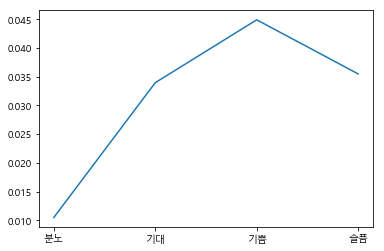

In [119]:
standard = ['분노','기대','기쁨','슬픔']
s=[]
for i in standard:
    s.append(sigmoid(model.wv.similarity('종강',i)))
plt.plot(standard,s)
plt.show()

In [39]:
#Draw Sentiment chart by above sentiment data
def draw_sent(df):
    df['분노'].plot(color='red')
    df['기대'].plot(color = 'yellow')
    df['기쁨'].plot(color = 'green')
    df['슬픔'].plot(color = 'blue')
    plt.show()
    print('분노-빨강')
    print('기대-노랑')
    print('기쁨-초록')
    print('슬픔-파랑')



# 5) 분석 결과<br>
우선 삼성의 갤럭시 폴드를 분석한 결과는 다음과 같다.

In [20]:
#갤럭시 폴드 
request_title('갤럭시 폴드')
request_comment('갤럭시 폴드')
df_comment_pos = pos_tagging('갤럭시 폴드')


Request Youtube Titles
----------------------------------
                                                title  \
0   갤럭시 폴드, 개발자가 알려주는 출시 연기 이유와 현재 삼성 상황!! 결함 원인 및...   
1                  드디어 갤럭시 폴드 출시일이 정해졌다! - 고동진 사장님 피셜   
2       갤럭시 폴드 출시임박 소식에 화웨이가 망연자실한 이유 / 결함논란 종결 [잡식왕]   
3            해외에서 리뷰하기 시작한 &quot;갤럭시폴드&quot;, 실사용기 영상   
4   삼성 갤럭시 폴드 구입을 고민한다면 꼭 보세요ㅣ폴더블폰 구입 전 알면 좋은 3가지ㅣ...   
5                 갤럭시폴드 6월 출시도 어렵나? , KBS의 갤럭시폴드 단독보도   
6      미국에서 대박난 갤럭시폴드 본 셀럽들 놀라운 반응!!오피셜 스펙 색상 디자인  포함   
7                             &#39;갤럭시 폴드&#39; 출격 완료?   
8                                  [갤럭시폴드] 결함원인이 밝혀지다   
9            삼성 갤럭시 노트 10, 프로 모델 추가 예상? 외: 주간텤 6월 두번째   
10          갤럭시 폴드 .. 직접 만져봤습니다. Galaxy Fold hands on   
11                 갤럭시 폴드 사전예약시작! Galaxy Fold Q&amp;A   
12      갤럭시폴드 출시 감감 무소식...삼성전자 &#39;산 넘어 산&#39; / YTN   
13                       갤럭시 폴드 5월 말 출시 확정, 어떻게 바뀌었나?   
14       삼성 갤럭시폴드가 지상파 뉴스에 나온 충격적인 이유, 그리고 지나버린 출시 시기   
15        갤럭시폴드 화면결함 이후 인기유투버들

      Unnamed: 0                                              title  \
0              0  갤럭시 폴드 패키징 상태를 봐도 기기가 접힌 상태로 포장되어있지 않은걸 봐선 기기를...   
1              1              제가 찾고있는부분인데 잘설명해주셔서감사해요 저랑성격이비슷하네요 ㅎㅎ   
2              2              왠지 유관 부서인듯 ㅎㅎㅎ 암튼 다른 리뷰보다 내용이 좀 알차네용    
3              3                                 흠 벌써 다 나왔던 얘기들입니다만   
4              4  출식 연기 됐다고 욕하고 빨리나왔는데 문제있다고 욕하고 자신들이 만들것도 아닌데 이...   
5              5                                       소리가   너무 울려요   
6              6                                    2월3월4월5월6월현기증난다   
7              7  삼성은 맨 쓰레기색기들모여서 그냥사고나지  회사말아먹을새끼들   부사장붙어짤라라  ...   
8              8                                    구독자 금방 늘겠다 잘봤어용   
9              9  폴드 자체는 이상적으론 좋은데 사실 시기상조 기술이지 않나 싶은생각 중간에 자국이 ...   
10            10           고동진 이새기 빨리짤랄 씨발 새끼 그냥사고치고있네 다음에는 회사말아먹는다   
11            11          발음도 좋고 소식도 빨라서 번창하실것같습니다 영상 잘 보고있어요 감사합니다   
12            12                                    항상 유익한 영상 감사합니ㅏ   
13    

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


50여개의 타이틀과 2967개의 댓글을 추출하였다.

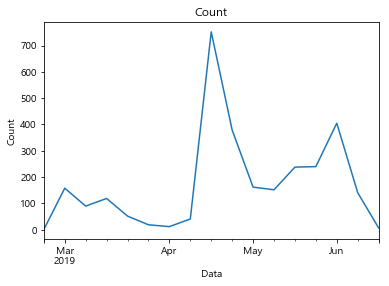

In [36]:
df_time_series = draw_time_series(df_comment_pos)


댓글의 빈도수를 분석한 결과 4월 말과 6월 초에 많은 것을 알 수 있다.
이는 4월 말 갤럭시 폴드 출시 임박과 함께 불거진 필름 주름 문제 때문임을 댓글량이 증가했음을 알 수 있다.

[('삼성', 621), ('폴드', 239), ('갤럭시', 228), ('출시', 220), ('생각', 218), ('제품', 212), ('세대', 203), ('문제', 201), ('기술', 178), ('영상', 157), ('사람', 151), ('필름', 151), ('더블', 137), ('진짜', 124), ('애플', 123), ('화면', 122), ('리뷰', 121), ('화웨이', 119), ('노트', 118), ('디스플레이', 110)]


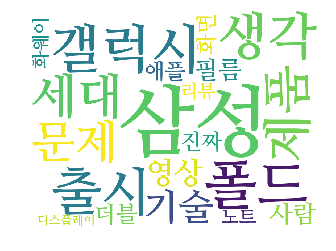

In [38]:
draw_wordcloud_all(df_time_series['title'])

삼성, 폴드, 갤럭시 순으로 단어의 빈도수가 많음을 알 수 있다. 특히 화웨이, 필름, 디스플레이, 세대, 문제의 키워드 또한 검색된 것을 알 수 있다.

2019-02-24T00:00:00.000000000


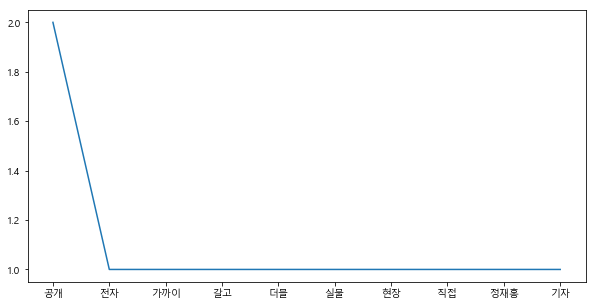

[('공개', 2), ('전자', 1), ('가까이', 1), ('갈고', 1), ('더블', 1), ('실물', 1), ('현장', 1), ('직접', 1), ('정재홍', 1), ('기자', 1), ('특공대', 1), ('사랑', 1), ('하이라이트', 1), ('미래', 1), ('저스틴', 1), ('데니', 1), ('삼성', 1), ('부사', 1), ('등장', 1), ('가지', 1)]


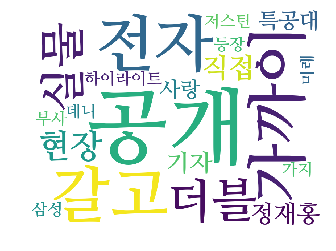

2019-03-03T00:00:00.000000000


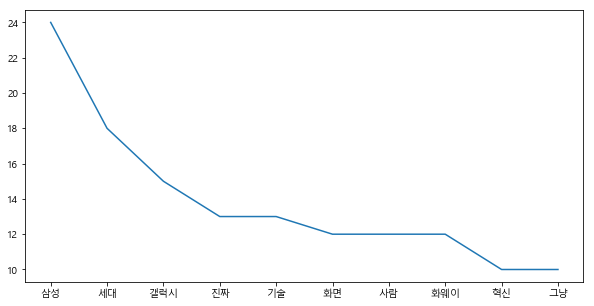

[('삼성', 24), ('세대', 18), ('갤럭시', 15), ('진짜', 13), ('기술', 13), ('화면', 12), ('사람', 12), ('화웨이', 12), ('혁신', 10), ('그냥', 10), ('폴드', 10), ('배터리', 10), ('디스플레이', 9), ('생각', 9), ('디자인', 7), ('지금', 6), ('노트', 6), ('긴장', 6), ('무게', 6), ('요미', 6)]


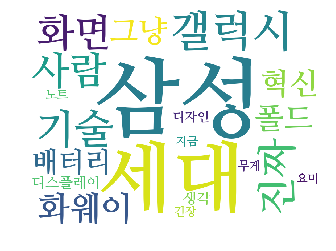

2019-03-10T00:00:00.000000000


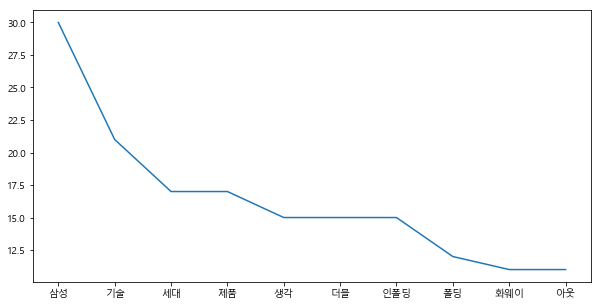

[('삼성', 30), ('기술', 21), ('세대', 17), ('제품', 17), ('생각', 15), ('더블', 15), ('인폴딩', 15), ('폴딩', 12), ('화웨이', 11), ('아웃', 11), ('정도', 9), ('때문', 9), ('주름', 9), ('방식', 9), ('가격', 8), ('영상', 8), ('출시', 8), ('사람', 8), ('보고', 7), ('개인', 7)]


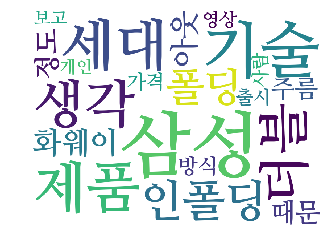

2019-03-17T00:00:00.000000000


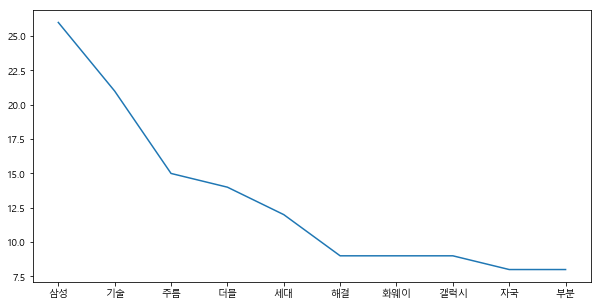

[('삼성', 26), ('기술', 21), ('주름', 15), ('더블', 14), ('세대', 12), ('해결', 9), ('화웨이', 9), ('갤럭시', 9), ('자국', 8), ('부분', 8), ('액정', 8), ('생각', 8), ('디스플레이', 7), ('제품', 7), ('문제', 7), ('그냥', 7), ('가격', 7), ('지금', 7), ('이제', 7), ('정도', 6)]


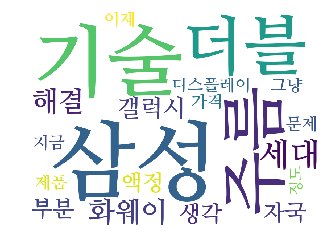

2019-03-24T00:00:00.000000000


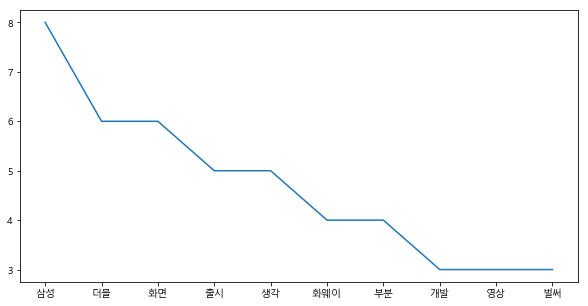

[('삼성', 8), ('더블', 6), ('화면', 6), ('출시', 5), ('생각', 5), ('화웨이', 4), ('부분', 4), ('개발', 3), ('영상', 3), ('벌써', 3), ('그냥', 3), ('완성', 3), ('주름', 3), ('자체', 3), ('이상', 3), ('자국', 3), ('정도', 3), ('아웃', 3), ('세대', 3), ('저런', 2)]


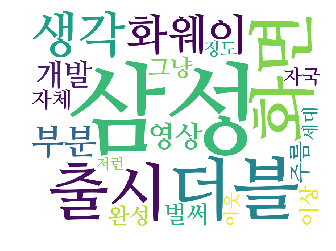

2019-03-31T00:00:00.000000000


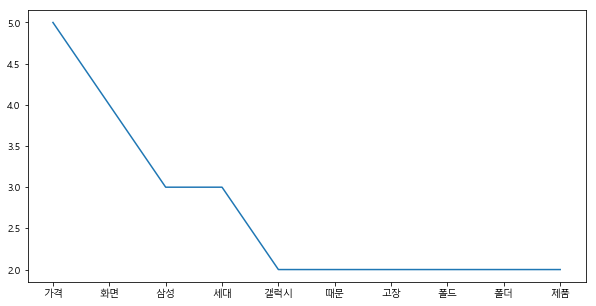

[('가격', 5), ('화면', 4), ('삼성', 3), ('세대', 3), ('갤럭시', 2), ('때문', 2), ('고장', 2), ('폴드', 2), ('폴더', 2), ('제품', 2), ('생각', 2), ('우리', 2), ('아빠', 2), ('폴라리스', 2), ('최고', 1), ('탱크', 1), ('안나', 1), ('화웨이', 1), ('보고', 1), ('부들부들', 1)]


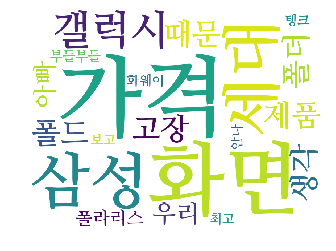

2019-04-07T00:00:00.000000000


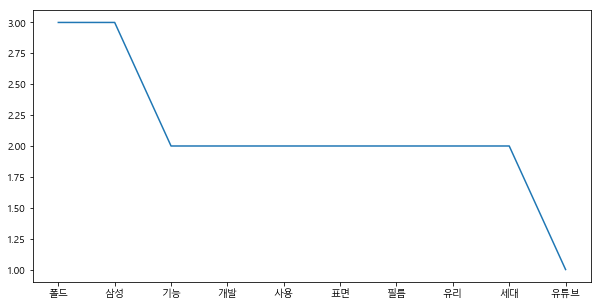

[('폴드', 3), ('삼성', 3), ('기능', 2), ('개발', 2), ('사용', 2), ('표면', 2), ('필름', 2), ('유리', 2), ('세대', 2), ('유튜브', 1), ('프리미엄', 1), ('보아', 1), ('인도', 1), ('프로그래머', 1), ('실물', 1), ('공급', 1), ('상당', 1), ('기간', 1), ('먼지', 1), ('잔뜩', 1)]


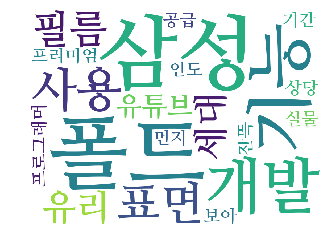

2019-04-14T00:00:00.000000000


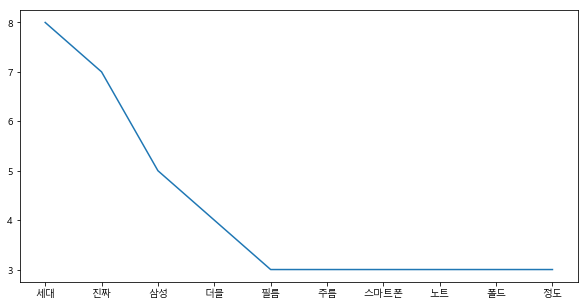

[('세대', 8), ('진짜', 7), ('삼성', 5), ('더블', 4), ('필름', 3), ('주름', 3), ('스마트폰', 3), ('노트', 3), ('폴드', 3), ('정도', 3), ('생각', 2), ('애플', 2), ('인정', 2), ('어색', 2), ('갤럭시', 2), ('디스플레이', 2), ('발전', 2), ('정말', 2), ('액정', 2), ('긴장', 2)]


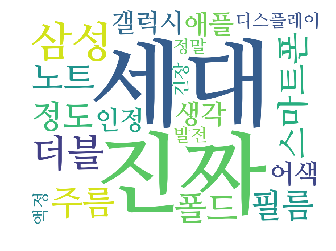

2019-04-21T00:00:00.000000000


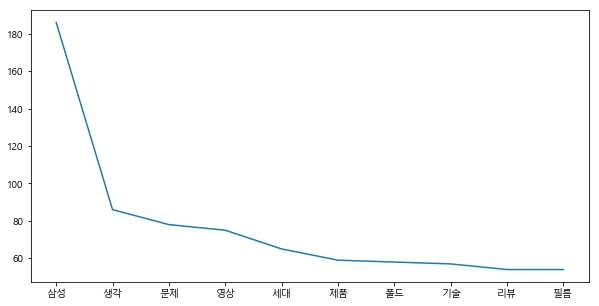

[('삼성', 186), ('생각', 86), ('문제', 78), ('영상', 75), ('세대', 65), ('제품', 59), ('폴드', 58), ('기술', 57), ('리뷰', 54), ('필름', 54), ('갤럭시', 51), ('노트', 48), ('화면', 46), ('지금', 45), ('사람', 42), ('애플', 37), ('진짜', 36), ('부분', 33), ('디스플레이', 33), ('보호', 33)]


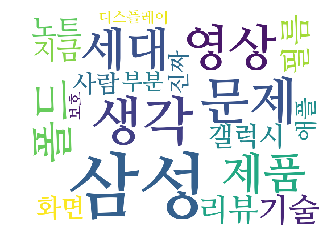

2019-04-28T00:00:00.000000000


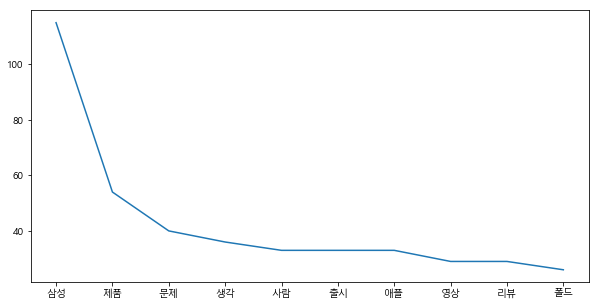

[('삼성', 115), ('제품', 54), ('문제', 40), ('생각', 36), ('사람', 33), ('출시', 33), ('애플', 33), ('영상', 29), ('리뷰', 29), ('폴드', 26), ('미국', 23), ('갤럭시', 23), ('고장', 22), ('필름', 21), ('세대', 21), ('진짜', 21), ('기술', 20), ('지금', 17), ('부분', 16), ('결함', 16)]


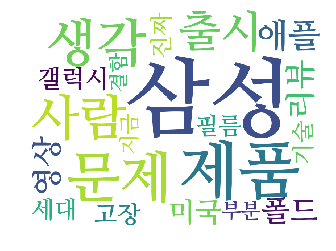

2019-05-05T00:00:00.000000000


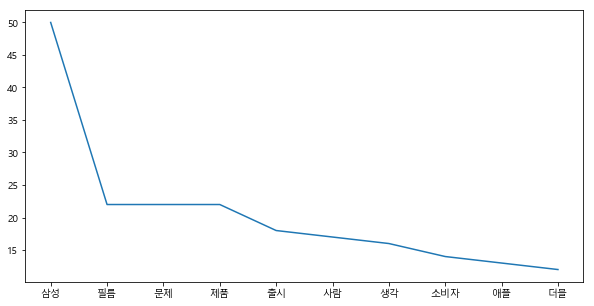

[('삼성', 50), ('필름', 22), ('문제', 22), ('제품', 22), ('출시', 18), ('사람', 17), ('생각', 16), ('소비자', 14), ('애플', 13), ('더블', 12), ('기술', 12), ('리뷰', 11), ('갤럭시', 11), ('세대', 10), ('폴드', 10), ('미국', 7), ('화웨이', 7), ('그냥', 7), ('노트', 7), ('거리', 6)]


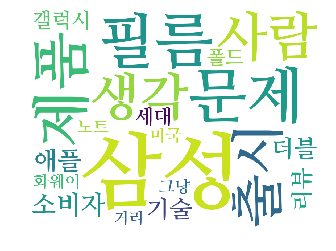

2019-05-12T00:00:00.000000000


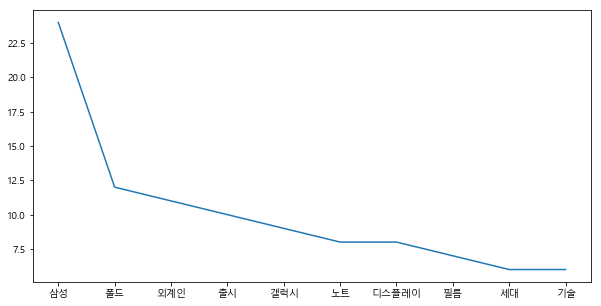

[('삼성', 24), ('폴드', 12), ('외계인', 11), ('출시', 10), ('갤럭시', 9), ('노트', 8), ('디스플레이', 8), ('필름', 7), ('세대', 6), ('기술', 6), ('지금', 6), ('이번', 6), ('영상', 6), ('애플', 6), ('소식', 5), ('물질', 5), ('미국', 5), ('성능', 5), ('진짜', 4), ('아이폰', 4)]


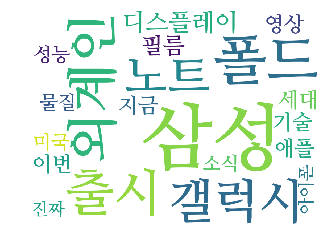

2019-05-19T00:00:00.000000000


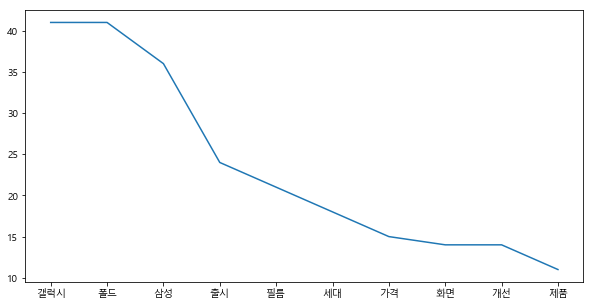

[('갤럭시', 41), ('폴드', 41), ('삼성', 36), ('출시', 24), ('필름', 21), ('세대', 18), ('가격', 15), ('화면', 14), ('개선', 14), ('제품', 11), ('불량', 10), ('배터리', 10), ('영상', 9), ('사람', 9), ('생각', 9), ('보호', 9), ('더블', 8), ('문제', 8), ('아이폰', 8), ('보조금', 8)]


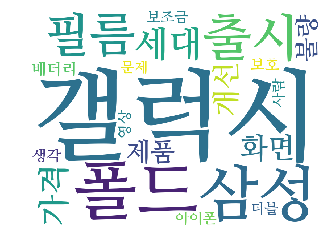

2019-05-26T00:00:00.000000000


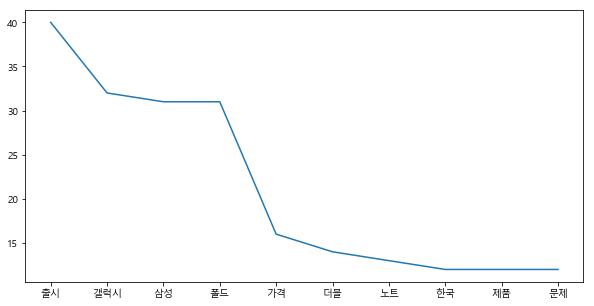

[('출시', 40), ('갤럭시', 32), ('삼성', 31), ('폴드', 31), ('가격', 16), ('더블', 14), ('노트', 13), ('한국', 12), ('제품', 12), ('문제', 12), ('화웨이', 11), ('기술', 11), ('세대', 11), ('디스플레이', 11), ('쓰레기', 10), ('미국', 9), ('정도', 9), ('부분', 9), ('태블릿', 8), ('기업', 8)]


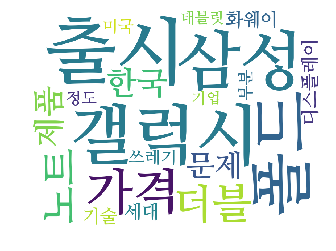

2019-06-02T00:00:00.000000000


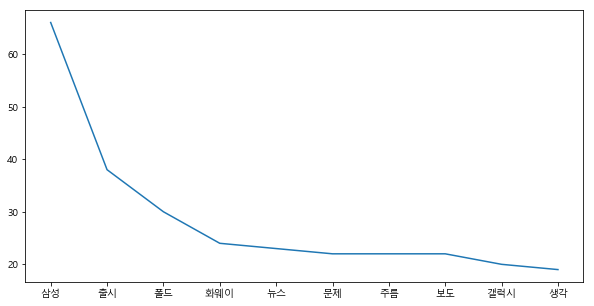

[('삼성', 66), ('출시', 38), ('폴드', 30), ('화웨이', 24), ('뉴스', 23), ('문제', 22), ('주름', 22), ('보도', 22), ('갤럭시', 20), ('생각', 19), ('한국', 18), ('더블', 15), ('리뷰', 15), ('방송', 14), ('부분', 13), ('사람', 13), ('개선', 13), ('제품', 11), ('이제', 11), ('디스플레이', 11)]


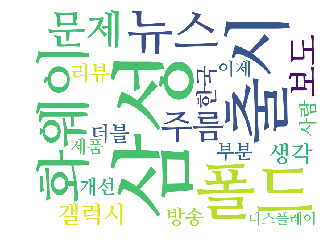

2019-06-09T00:00:00.000000000


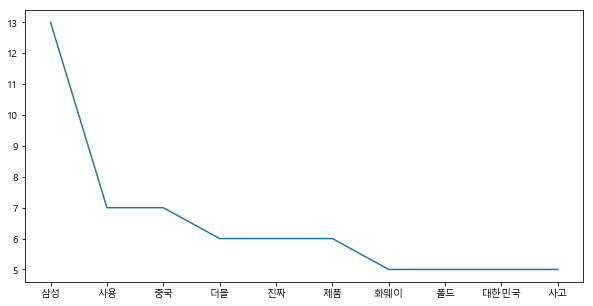

[('삼성', 13), ('사용', 7), ('중국', 7), ('더블', 6), ('진짜', 6), ('제품', 6), ('화웨이', 5), ('폴드', 5), ('대한민국', 5), ('사고', 5), ('삼전', 5), ('출시', 4), ('화면', 4), ('정부', 4), ('기업', 4), ('갤럭시', 4), ('생각', 4), ('자체', 4), ('영상', 4), ('미국', 4)]


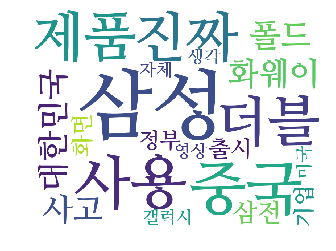

2019-06-16T00:00:00.000000000


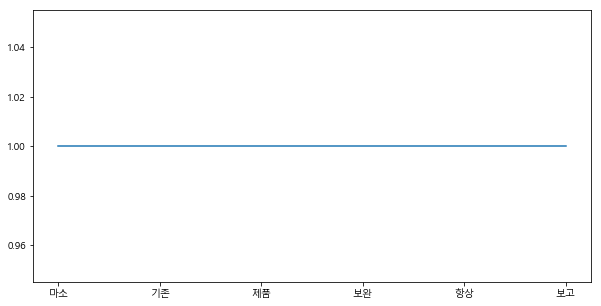

[('마소', 1), ('기존', 1), ('제품', 1), ('보완', 1), ('항상', 1), ('보고', 1)]


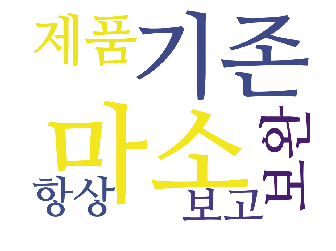

In [45]:
for i in range(len(df_time_series['title'])):
    print(df_time_series.index.values[i])
    draw_frequency(df_time_series['title'][i])
    draw_wordcloud(df_time_series['title'][i])


주별 단어의 빈도수와 키워드를 분석한 결과는 위와 같다.

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                                       title  \
date                                                                           
2019-02-24 00:00:00+00:00  [(삼, Modifier), (성, Modifier), (전자, Noun), (가,...   
2019-03-03 00:00:00+00:00  [(오우, Noun), (신기하다, Adjective), (뎅, Noun), (애플...   
2019-03-10 00:00:00+00:00  [(두껍다, Adjective), (베젤, Noun), (은, Josa), (내부,...   
2019-03-17 00:00:00+00:00  [(사실, Noun), (몇, Noun), (년, Noun), (전, Noun), ...   
2019-03-24 00:00:00+00:00  [(자막, Noun), (이, Josa), (엄청, Adverb), (작다, Adj...   
2019-03-31 00:00:00+00:00  [(이, Noun), (게, Josa), (다, Adverb), (갤럭시, Noun...   
2019-04-07 00:00:00+00:00  [(101, Number), (이, Determiner), (것, Noun), (은...   
2019-04-14 00:00:00+00:00  [(출시일, Noun), (이, Josa), (2018년, Number), (이에요...   
2019-04-21 00:00:00+00:00  [(개발, Noun), (한, Determiner), (건, Noun), (대단하다...   
2019-04-28 00:00:00+00:00  [(현재, Noun), (문제, Noun), (제기, Noun), (되다, Verb...   
2019-05-05 00:00:00+00:00  [(나다, Verb), 

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


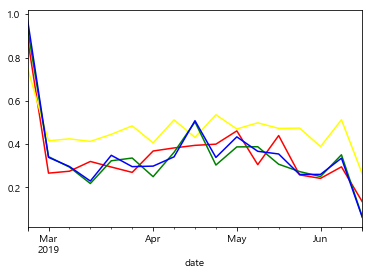

분노-빨강
기대-노랑
기쁨-초록
슬픔-파랑


In [46]:
df_sent = Analyze_sentiment(df_time_series)
draw_sent(df_sent)

감정 추이를 분석한 결과는 다음과 같다. 대체적으로 '기대'의 감정이 높으며 4월 중순 기쁨과 슬픔의 감정이 갑자기 높아진 것을 볼 수 있다. 이는 갤럭시 폴드 출시 및 연기 관련이 있는 것으로 보인다.
또한 분노의 감정은 달마다 점차 커지다 5월 중반 이후로 다시 떨어지는 것을 볼 수 있다

### 위와 같은 방식으로 '손흥민'을 분석한 결과는 다음과 같다

In [47]:
#손흥민
request_title('손흥민')
request_comment('손흥민')
df_comment_pos = pos_tagging('손흥민')

Request Youtube Titles
----------------------------------
                                                title  \
0   조부상 전해 들은 이승우 꼭 안고 위로하는 손흥민 ‘쓰담쓰담’ 축구국가대표팀 훈련 ...   
1   [18/19 EPL 시즌결산] 토트넘 #1 &#39;손흥민 vs 시소코&#39; 현...   
2                                   2018-19시즌 손흥민 총결산   
3                              [풋매골인터뷰] 손흥민 (300회 특집)   
4   [축구직캠] &#39;손흥민&#39;만 찍어보았습니다. (feat. 김민재, 황희찬...   
5   집돌이 손흥민은 집에서 뭘하며 지낼까? Sonsational: The Making ...   
6                        손흥민 만나러 저희랑 같이 런던 가실 분을 찾습니다   
7   경기후 울음을 터뜨리는 손흥민과 안아주는 클롭, 리버풀 선수단..토트넘 리버풀 챔스...   
8   [축구직캠] 벤투 감독을 빵 터지게 한 손흥민의 장난기 가득한 돌발 행동! / 파워...   
9                  손흥민 인성을 알 수 있었던 챔스 결승 현장 (챔스 뒷이야기)   
10  손흥민 x 앙리 x 박지성! 레전드들이 말하는 프리미어리그 Sonsational: ...   
11  경기후 호주 전 선수단과 인사하는 손흥민! 집중견제 활약상! 대한민국 한국 호주 s...   
12          [대한민국:호주 평가전] 황의조, 손흥민 부산을 뒤집다! 4분 하이라이트!   
13     &quot;호주 이란 잡으러 왔어요~&quot; 국대 훈련 합류한 손흥민 풀인터뷰!   
14          해외파 선배들에게 물었다! 내가 손흥민이면 레알 마드리드 간다? 안간다??   
15                     함부르크에 가

      Unnamed: 0                                              title  \
0              0  승우형 항상 밝은 모습 보여줘서 고맙고 내 할아버지는 분명 형을 응원하고 계실거야 ...   
1              1                후배선수들 배려해주는 마음까지 우리 캡틴 손흥민선수 이승우 내자   
2              2                                         손흥민 참 고생한다   
3              3  승우야 비록 할아버지와 이별을해서 슬프겠지만 너희 할아버지는 경기장을 직접 찾아가지...   
4              4                            삼가고인의 명복을 빕니다 승우선수님 내세요   
5              5                                     삼가 고인의 명복을 빕니다   
6              6                트리피어 자살골 다시보니 개웃기네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ   
7              7  0621 라멜라 ㅇㅈ합니다 시즌 초반엔 괜찮았는데 시즌 진행할수록 계속 햄스트링 엉...   
8              8  영상 항상 잘보고 있습니다 딴지는 아니지만 607가 blindly가 아니라 혹시 b...   
9              9                   첼시결산도 혹시 가능하신가여ㅠㅠ첼시팬으로서 너무 궁금합니다   
10            10  시스코가 올시즌 기복없이 꾸준히 잘하긴했지손흥민 단점이 기복이라 꾸준함만 갖춘다면 ...   
11            11                유럽 축구팬들은 보면 항상 피지컬적인 선수에 대한 로망이 있는듯   
12            12  트리피어는 진짜 월드컵이후로 폼이 너무 떨어진지라 당연히 워스트가 맏다고봄 개인적으...   
13    

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


      Unnamed: 0                                              title  \
0              0  [(승, Noun), (우형, Noun), (항상, Noun), (밝다, Verb)...   
1              1  [(후배, Noun), (선수, Noun), (들, Suffix), (배려, Nou...   
2              2  [(손흥민, Noun), (차다, Verb), (고생, Noun), (하다, Verb)]   
3              3  [(승, Noun), (우야, Adverb), (비록, Noun), (할아버지, N...   
4              4  [(삼가다, Verb), (명복, Noun), (을, Josa), (비다, Verb...   
5              5  [(삼가다, Verb), (고인, Noun), (의, Josa), (명복, Noun...   
6              6  [(트리, Noun), (피어, Noun), (자살골, Noun), (다시, Nou...   
7              7  [(0621, Number), (라멜라, Noun), (ㅇㅈ, KoreanParti...   
8              8  [(영상, Noun), (항상, Noun), (잘, VerbPrefix), (보다,...   
9              9  [(첼시, Noun), (결산, Noun), (도, Josa), (혹시, Noun)...   
10            10  [(시스코, Noun), (가, Josa), (올, Modifier), (시즌, N...   
11            11  [(유럽, Noun), (축구, Noun), (팬, Noun), (들, Suffix...   
12            12  [(트리, Noun), (피어, Noun), (는, Josa), (진짜, Noun)...   
13    

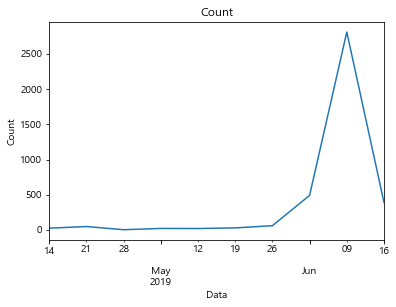

In [48]:
df_time_series = draw_time_series(df_comment_pos)

[('손흥민', 800), ('선수', 520), ('진짜', 322), ('토트넘', 264), ('케인', 200), ('흥민', 193), ('경기', 185), ('축구', 173), ('리버풀', 156), ('챔스', 151), ('사람', 134), ('영상', 131), ('결승', 127), ('우리', 122), ('생각', 121), ('정말', 111), ('시즌', 109), ('우승', 106), ('응원', 103), ('레알', 93)]


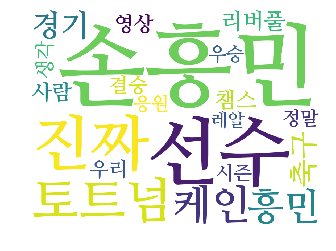

In [49]:
draw_wordcloud_all(df_time_series['title'])

2019-04-14T00:00:00.000000000


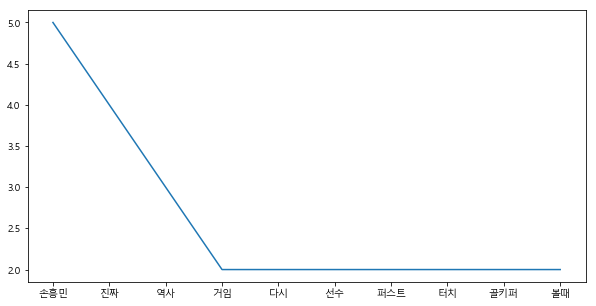

[('손흥민', 5), ('진짜', 4), ('역사', 3), ('거임', 2), ('다시', 2), ('선수', 2), ('퍼스트', 2), ('터치', 2), ('골키퍼', 2), ('볼때', 2), ('소리', 2), ('이유', 1), ('결승골', 1), ('기기', 1), ('벤치', 1), ('성과', 1), ('취소', 1), ('경기', 1), ('필드', 1), ('서로', 1)]


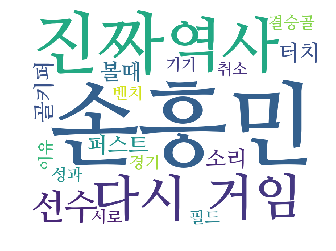

2019-04-21T00:00:00.000000000


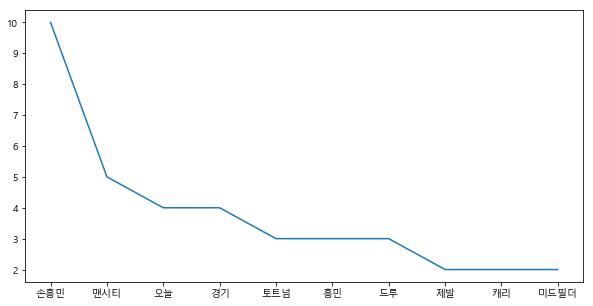

[('손흥민', 10), ('맨시티', 5), ('오늘', 4), ('경기', 4), ('토트넘', 3), ('흥민', 3), ('드루', 3), ('제발', 2), ('캐리', 2), ('미드필더', 2), ('대한민국', 2), ('몇번', 2), ('보고', 2), ('영상', 2), ('얼마', 2), ('진짜', 2), ('번은', 2), ('정답', 2), ('결승', 1), ('대진표', 1)]


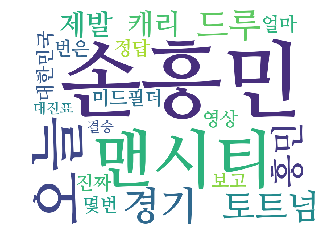

2019-04-28T00:00:00.000000000


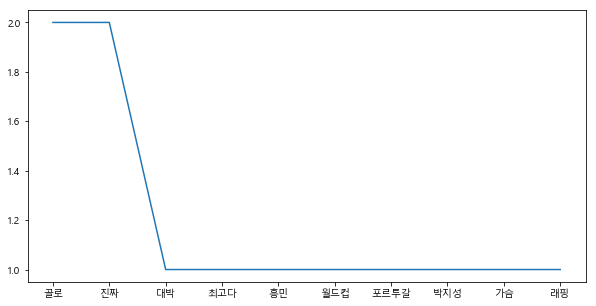

[('골로', 2), ('진짜', 2), ('대박', 1), ('최고다', 1), ('흥민', 1), ('월드컵', 1), ('포르투갈', 1), ('박지성', 1), ('가슴', 1), ('래핑', 1), ('오른발', 1), ('컨트롤', 1), ('수비', 1), ('하나', 1), ('왼발', 1), ('슈팅', 1), ('거의', 1), ('정말', 1), ('집중', 1), ('집념', 1)]


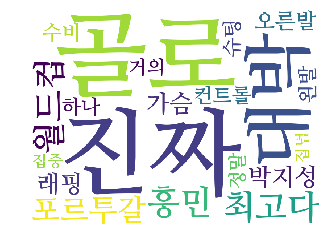

2019-05-05T00:00:00.000000000


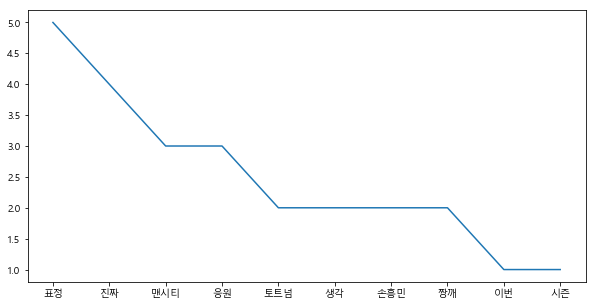

[('표정', 5), ('진짜', 4), ('맨시티', 3), ('응원', 3), ('토트넘', 2), ('생각', 2), ('손흥민', 2), ('짱깨', 2), ('이번', 1), ('시즌', 1), ('관건', 1), ('챔스', 1), ('결승', 1), ('견인', 1), ('무조건', 1), ('마지막', 1), ('전성기', 1), ('정화', 1), ('이기', 1), ('누가', 1)]


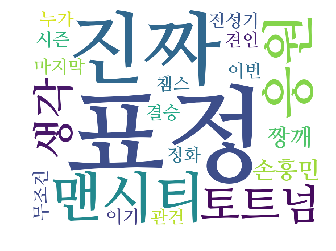

2019-05-12T00:00:00.000000000


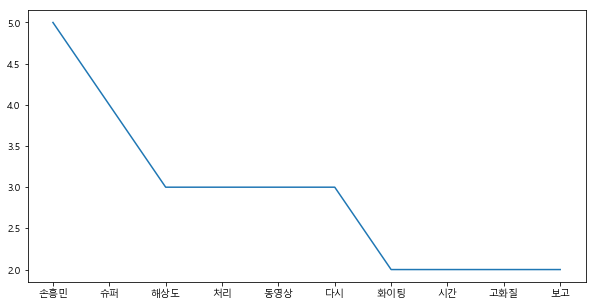

[('손흥민', 5), ('슈퍼', 4), ('해상도', 3), ('처리', 3), ('동영상', 3), ('다시', 3), ('화이팅', 2), ('시간', 2), ('고화질', 2), ('보고', 2), ('아약스', 2), ('덕분', 2), ('결승', 2), ('옛날', 1), ('다른', 1), ('약간', 1), ('표정', 1), ('별로', 1), ('베르나르도', 1), ('실바', 1)]


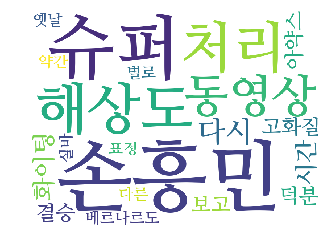

2019-05-19T00:00:00.000000000


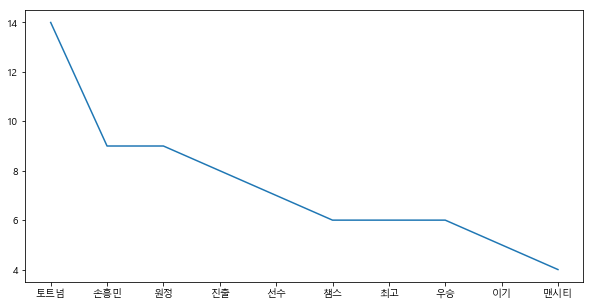

[('토트넘', 14), ('손흥민', 9), ('원정', 9), ('진출', 8), ('선수', 7), ('챔스', 6), ('최고', 6), ('우승', 6), ('이기', 5), ('맨시티', 4), ('표정', 4), ('역사', 4), ('성적', 4), ('아약스', 4), ('시간', 4), ('생각', 3), ('리그', 3), ('인테르', 3), ('상대', 3), ('활약', 3)]


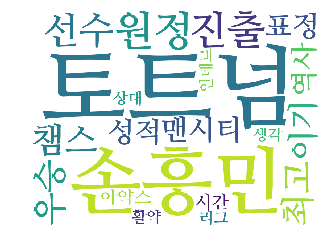

2019-05-26T00:00:00.000000000


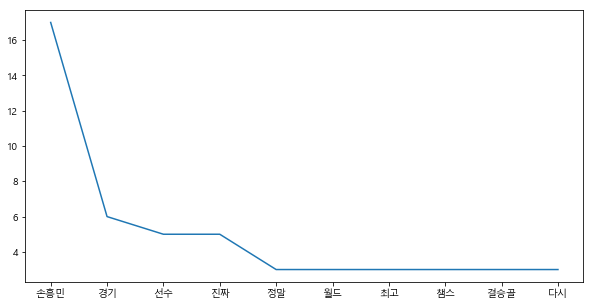

[('손흥민', 17), ('경기', 6), ('선수', 5), ('진짜', 5), ('정말', 3), ('월드', 3), ('최고', 3), ('챔스', 3), ('결승골', 3), ('다시', 3), ('국뽕', 3), ('영상', 3), ('보고', 3), ('축구', 3), ('몇번', 2), ('하루', 2), ('마라도나', 2), ('모자', 2), ('결승', 2), ('에릭', 2)]


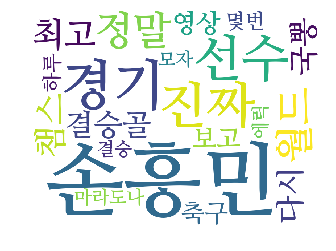

2019-06-02T00:00:00.000000000


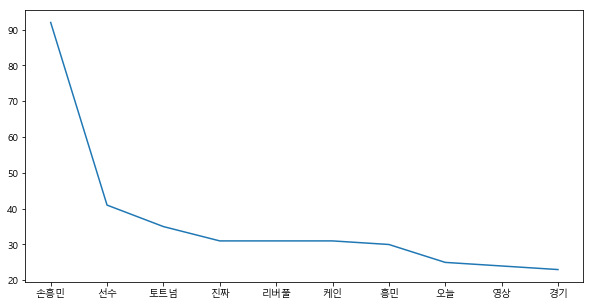

[('손흥민', 92), ('선수', 41), ('토트넘', 35), ('진짜', 31), ('리버풀', 31), ('케인', 31), ('흥민', 30), ('오늘', 25), ('영상', 24), ('경기', 23), ('챔스', 22), ('우승', 22), ('결승', 17), ('슈퍼', 17), ('사람', 14), ('해리', 14), ('지금', 13), ('화이팅', 12), ('정말', 11), ('리그', 11)]


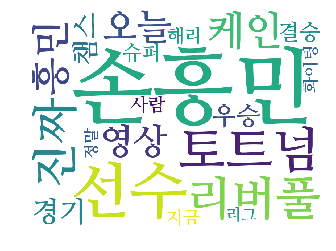

2019-06-09T00:00:00.000000000


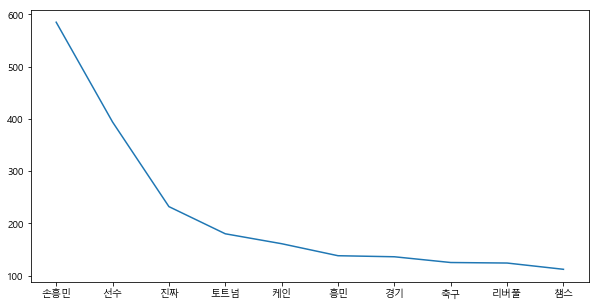

[('손흥민', 585), ('선수', 394), ('진짜', 232), ('토트넘', 180), ('케인', 161), ('흥민', 138), ('경기', 136), ('축구', 125), ('리버풀', 124), ('챔스', 112), ('사람', 112), ('결승', 99), ('우리', 95), ('생각', 93), ('정말', 90), ('앙리', 88), ('영상', 84), ('응원', 80), ('시즌', 73), ('화이팅', 68)]


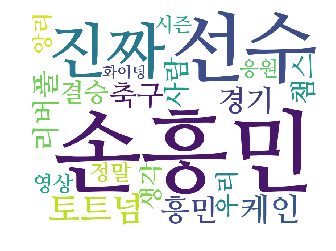

2019-06-16T00:00:00.000000000


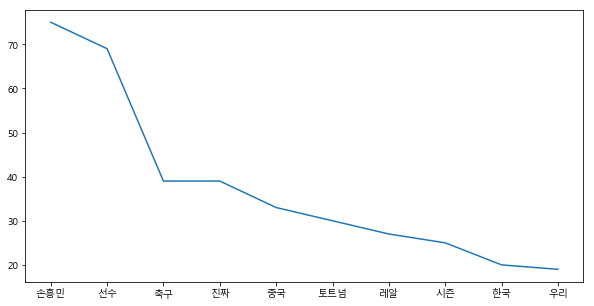

[('손흥민', 75), ('선수', 69), ('축구', 39), ('진짜', 39), ('중국', 33), ('토트넘', 30), ('레알', 27), ('시즌', 25), ('한국', 20), ('우리', 19), ('프리미어리그', 19), ('흥민', 17), ('생각', 16), ('우레이', 16), ('호골', 16), ('영상', 16), ('경기', 14), ('월드컵', 13), ('도움', 13), ('응원', 12)]


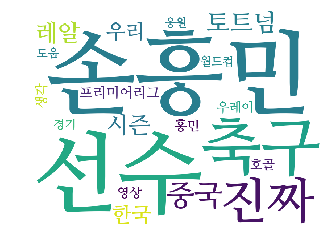

In [50]:
for i in range(len(df_time_series['title'])):
    print(df_time_series.index.values[i])
    draw_frequency(df_time_series['title'][i])
    draw_wordcloud(df_time_series['title'][i])


C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                                       title  \
date                                                                           
2019-04-14 00:00:00+00:00  [(이, Noun), (게, Josa), (더, Noun), (빛나다, Verb),...   
2019-04-21 00:00:00+00:00  [(결승, Noun), (대진표, Noun), (예상, Noun), (토트넘, No...   
2019-04-28 00:00:00+00:00  [(대박, Noun), (최고다, Noun), (흥민, Noun), (이, Josa...   
2019-05-05 00:00:00+00:00  [(진짜, Noun), (이번, Noun), (시즌, Noun), (이, Josa)...   
2019-05-12 00:00:00+00:00  [(솔직하다, Adjective), (말, Noun), (하다, Verb), (옛날...   
2019-05-19 00:00:00+00:00  [(ZD, Alpha), (좆, Noun), (돼다, Verb), (손흥민, Nou...   
2019-05-26 00:00:00+00:00  [(어, Eomi), (ㅋㅋㅋ, KoreanParticle), (손, Noun), ...   
2019-06-02 00:00:00+00:00  [(설마, Noun), (추, Noun), (ㅡ, KoreanParticle), (...   
2019-06-09 00:00:00+00:00  [(재밌다, Adjective), (다흐, Noun), (격, Noun), (없이,...   
2019-06-16 00:00:00+00:00  [(30, Number), (대다, Verb), (게, Noun), (제일, Nou...   

                           count       

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


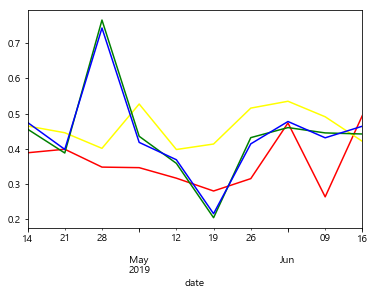

분노-빨강
기대-노랑
기쁨-초록
슬픔-파랑


In [51]:
df_sent = Analyze_sentiment(df_time_series)
draw_sent(df_sent)

### 위와 같은 방식으로 '문재인'을 분석한 결과는 다음과 같다

In [63]:

request_title('문재인')
request_comment('문재인')
df_comment_pos = pos_tagging('문재인')


Request Youtube Titles
----------------------------------
                                                title  \
0                        한-핀란드 공동언론발표 문재인 대통령 모두발언 전문   
1     6·10 기념식도 불참…황교안 &quot;문재인 정권, 역대 가장 비민주적&quot;   
2         차명진, 8차례 수정 거쳐 &quot;문재인은 빨갱이&quot; 또 막말 파장   
3   문재인 대통령 &#39;혁신, 포용, 평화&#39;의 의미를 담고 출발한 북유럽 3...   
4         [노브레이크 토크] ‘범생’ 유은혜, ‘노무현 문재인 변호사 사무소’에는 왜?   
5       문재인 대통령 &quot;국회, 추경 급한데 심사조차 안 해&quot; / YTN   
6                [오늘의 키워드]  문재인 대통령, 김원봉 언급…공적 논란 재점화   
7                     문재인 대통령, 북유럽 3개국 순방 위해 출국 / YTN   
8                     문재인 대통령 X 일 잘하는 자랑스러운 공무원 초청 오찬   
9   문재인 대통령과 김경수 경남도지사 옆에 선 옐로우의 반응...? 미세먼지 해결 홍보...   
10                   [영상] 새 대한민국 연 문재인…그가 걸어온 인생·정치역정   
11            [현장영상] 제64회 현충일 추념식...문재인 대통령 추념사 / YTN   
12  볼륨주의! 문재인 대통령 청주중앙공원에 갔더니...시민들 함성으로 시작해 울음으로 ...   
13                               문재인 대통령 지지율 추이를 정리했다   
14                 [다시보기] 문재인 정부 2년 특집 대담 - 대통령에게 묻는다   
15  문재인 대통령, 김경수 경남도지사가 창원에서 아

      Unnamed: 0                                              title  \
0              0  핀란드는 리눅스를 만든 라이너스 토발즈의 나라입니다리눅스의 아버지이자 안드로이드의 ...   
1              1      대통령님내시고 건강히 조심히다녀오셔요 어딘지모르게 음성에 이약해보입니다 지지합니다   
2              2                                          얼굴도 보기 싫타   
3              3                                         문재인대통령님 최고   
4              4         세상 참 많이 변했다 이명박 박근혜대통령때 같았으면 생중계하고 난리쳤을 건데   
5              5           양국이 서로 발전하는 성공적인  관계가 되길 바랍니다 대통령님 감사합니다   
6              6  문대통령님 보며 대한민국 국민임이 너무 자랑스럽습니다한편 토착왜구당 때문에 드신 대...   
7              7                             평화가 곧 경제다어찌보면 유일한 돌파구다   
8              8                 훌륭하신  대통령님이 계셔서 너무 행복합니다 늘 건강 챙기세요   
9              9  에휴 인간들아 정신차려 ㅠㅠ 아따위 쑈는 굳이 정치가 아니라도 그냥 3류 영화도 연...   
10            10  세계정세를 보면 알수있다핀란드의 대통령의 웃고 아닌듯한 표정 모두 정치의 부분이다 ...   
11            11                A4지도 제대로 못 읽네 바보가 말귀도 못 알아듣고 동문서답하고   
12            12  매국당과 같이 가는 섞어 빠진 언론정말 언론이라하기싫지만과  기사가 뭔지 모르는 기...   
13    

C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


      Unnamed: 0                                              title  \
0              0  [(핀란드, Noun), (는, Josa), (리눅스, Noun), (를, Josa...   
1              1  [(대통령, Noun), (님, Suffix), (내시, Noun), (고, Jos...   
2              2  [(얼굴, Noun), (도, Josa), (보기, Noun), (싫다, Adjec...   
3              3  [(문재인, Noun), (대통령, Noun), (님, Suffix), (최고, N...   
4              4  [(세상, Noun), (차다, Verb), (많이, Adverb), (변하다, A...   
5              5  [(양국, Noun), (이, Josa), (서로, Noun), (발전, Noun)...   
6              6  [(문, Modifier), (대통령, Noun), (님, Suffix), (보다,...   
7              7  [(평화, Noun), (가, Josa), (곧, Noun), (경제, Noun),...   
8              8  [(훌륭하다, Adjective), (대통령, Noun), (님, Suffix), ...   
9              9  [(에, Josa), (휴, Exclamation), (인간, Noun), (들, ...   
10            10  [(세계, Noun), (정세, Noun), (를, Josa), (보다, Verb)...   
11            11  [(A, Alpha), (4, Number), (지도, Noun), (제대로, No...   
12            12  [(매국, Noun), (당, Suffix), (과, Josa), (같이, Adve...   
13    

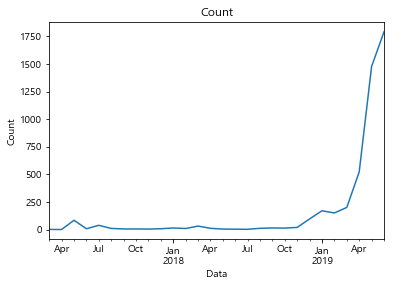

In [90]:
df_time_series = draw_time_series_M(df_comment_pos)
df_time_series = df_time_series.drop(df_time_series.index[1:2])

[('대통령', 1317), ('문재인', 671), ('국민', 470), ('나라', 420), ('사람', 363), ('우리', 254), ('북한', 237), ('새끼', 232), ('진짜', 228), ('대한민국', 216), ('생각', 208), ('재앙', 185), ('지금', 168), ('경제', 160), ('사랑', 158), ('빨갱이', 149), ('정부', 143), ('국가', 142), ('지지', 141), ('정말', 140)]


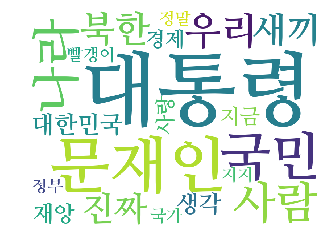

In [91]:
draw_wordcloud_all(df_time_series['title'])

2017-03-31T00:00:00.000000000


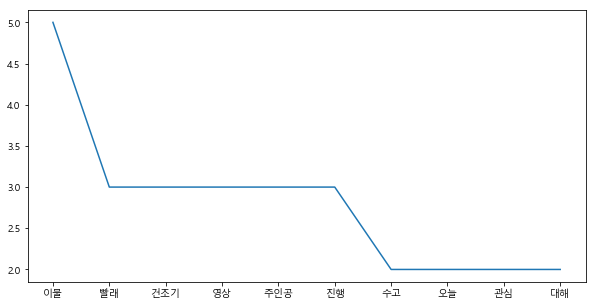

[('이불', 5), ('빨래', 3), ('건조기', 3), ('영상', 3), ('주인공', 3), ('진행', 3), ('수고', 2), ('오늘', 2), ('관심', 2), ('대해', 2), ('처음', 2), ('장면', 2), ('하루', 2), ('촬영', 2), ('진입', 1), ('항상', 1), ('우선', 1), ('답변', 1), ('세탁기', 1), ('추후', 1)]


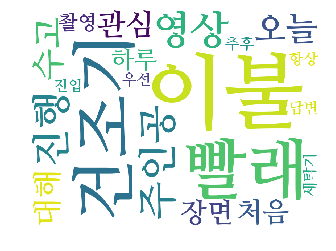

2017-05-31T00:00:00.000000000


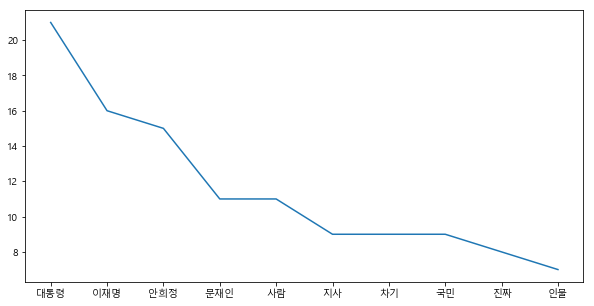

[('대통령', 21), ('이재명', 16), ('안희정', 15), ('문재인', 11), ('사람', 11), ('지사', 9), ('차기', 9), ('국민', 9), ('진짜', 8), ('인물', 7), ('노무현', 6), ('민주당', 6), ('김부겸', 5), ('정부', 5), ('지지', 5), ('북한', 5), ('우리', 4), ('대선', 4), ('생각', 4), ('보기', 4)]


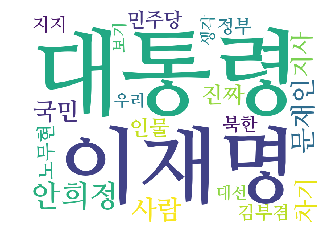

2017-06-30T00:00:00.000000000


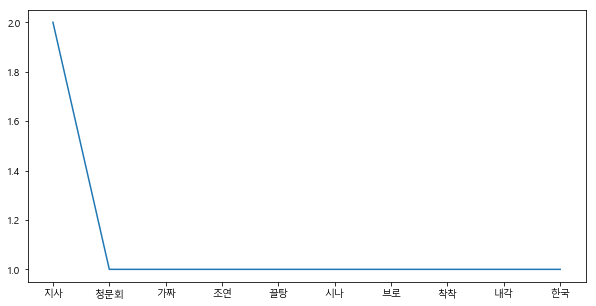

[('지사', 2), ('청문회', 1), ('가짜', 1), ('조연', 1), ('끌탕', 1), ('시나', 1), ('브로', 1), ('착착', 1), ('내각', 1), ('한국', 1), ('국민당', 1), ('대한민국', 1), ('안희정', 1), ('졸귀', 1), ('음주', 1), ('연설', 1), ('표남', 1), ('지금', 1), ('이불', 1), ('문재인', 1)]


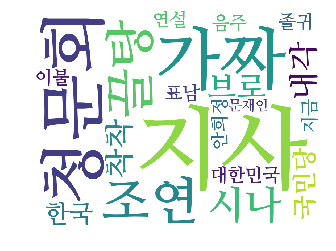

2017-07-31T00:00:00.000000000


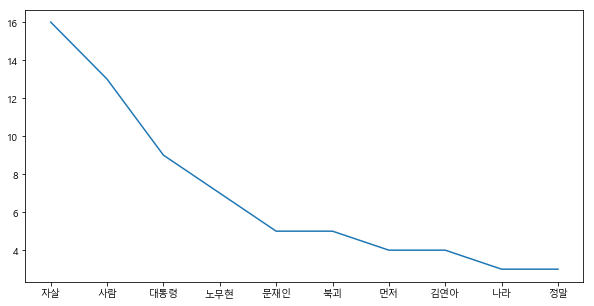

[('자살', 16), ('사람', 13), ('대통령', 9), ('노무현', 7), ('문재인', 5), ('북괴', 5), ('먼저', 4), ('김연아', 4), ('나라', 3), ('정말', 3), ('웃음', 3), ('보기', 3), ('새끼', 3), ('올림픽', 3), ('미화', 3), ('보고', 2), ('얼굴', 2), ('재앙', 2), ('국민', 2), ('평창올림픽', 2)]


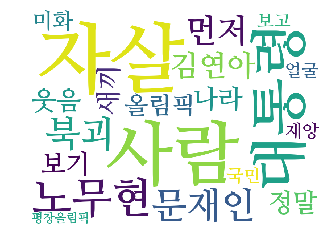

2017-08-31T00:00:00.000000000


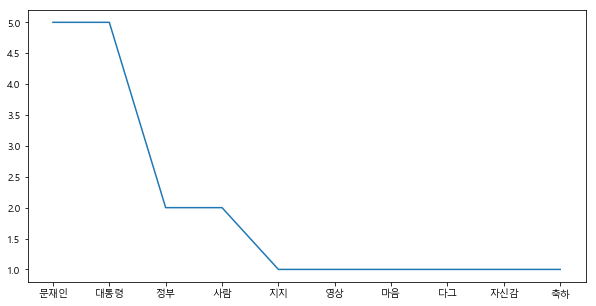

[('문재인', 5), ('대통령', 5), ('정부', 2), ('사람', 2), ('지지', 1), ('영상', 1), ('마음', 1), ('다그', 1), ('자신감', 1), ('축하', 1), ('웃음', 1), ('아음', 1), ('지는느낑', 1), ('마치', 1), ('좀비', 1), ('냄새', 1), ('전혀', 1), ('꾸밈', 1), ('신분', 1), ('한국', 1)]


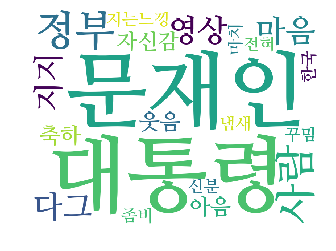

2017-09-30T00:00:00.000000000


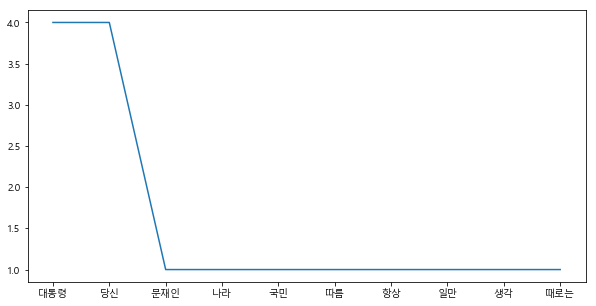

[('대통령', 4), ('당신', 4), ('문재인', 1), ('나라', 1), ('국민', 1), ('따름', 1), ('항상', 1), ('일만', 1), ('생각', 1), ('때로는', 1), ('실망', 1), ('일도', 1), ('추구', 1), ('방향', 1), ('진정', 1), ('대한민국', 1), ('확신', 1), ('지지', 1), ('감동', 1), ('진짜', 1)]


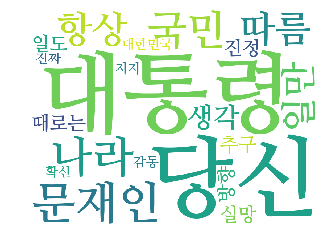

2017-10-31T00:00:00.000000000


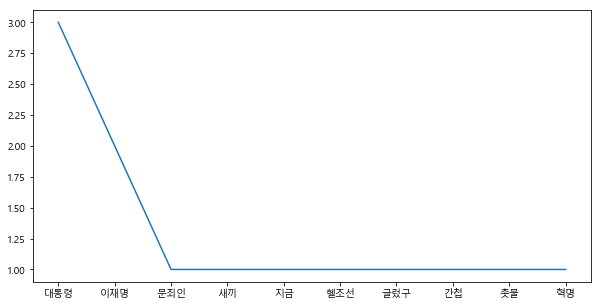

[('대통령', 3), ('이재명', 2), ('문죄인', 1), ('새끼', 1), ('지금', 1), ('헬조선', 1), ('글렀구', 1), ('간첩', 1), ('촛불', 1), ('혁명', 1), ('문재인', 1), ('멘트', 1), ('일품', 1), ('절대', 1), ('더티', 1), ('과정', 1), ('결과', 1), ('용서', 1)]


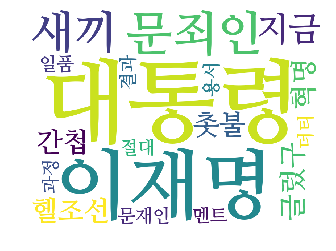

2017-11-30T00:00:00.000000000


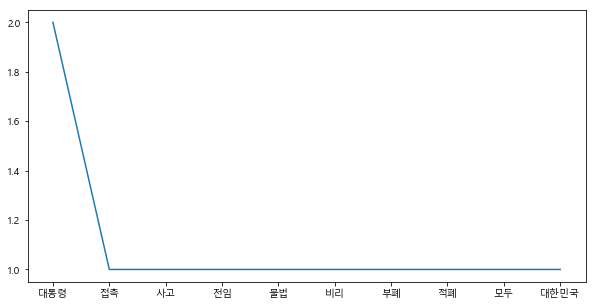

[('대통령', 2), ('접촉', 1), ('사고', 1), ('전임', 1), ('불법', 1), ('비리', 1), ('부폐', 1), ('적폐', 1), ('모두', 1), ('대한민국', 1), ('폐가', 1), ('존재', 1), ('해주시', 1), ('엄지', 1), ('우울', 1), ('마음', 1)]


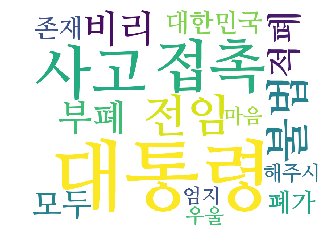

2017-12-31T00:00:00.000000000


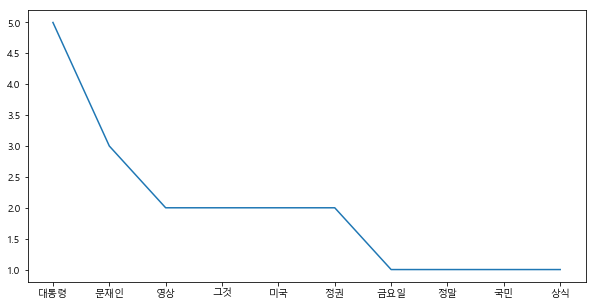

[('대통령', 5), ('문재인', 3), ('영상', 2), ('그것', 2), ('미국', 2), ('정권', 2), ('금요일', 1), ('정말', 1), ('국민', 1), ('상식', 1), ('국정', 1), ('운영', 1), ('야당', 1), ('비상', 1), ('행태', 1), ('자행', 1), ('지방선거', 1), ('통해', 1), ('적폐', 1), ('세력', 1)]


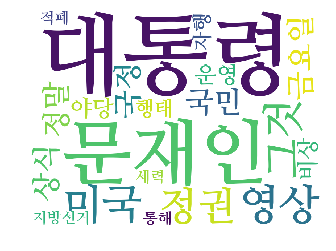

2018-01-31T00:00:00.000000000


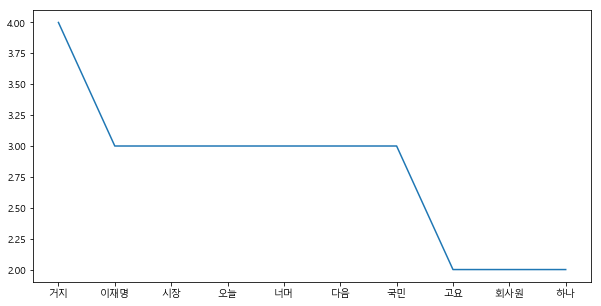

[('거지', 4), ('이재명', 3), ('시장', 3), ('오늘', 3), ('너머', 3), ('다음', 3), ('국민', 3), ('고요', 2), ('회사원', 2), ('하나', 2), ('욕설', 2), ('비방', 2), ('모욕', 2), ('이하', 2), ('취임식', 2), ('대통', 1), ('세상', 1), ('만듭시', 1), ('감격', 1), ('최성', 1)]


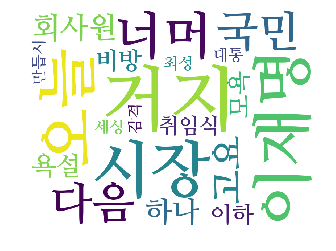

2018-02-28T00:00:00.000000000


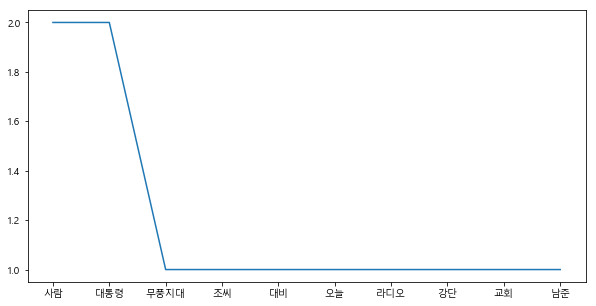

[('사람', 2), ('대통령', 2), ('무풍지대', 1), ('조씨', 1), ('대비', 1), ('오늘', 1), ('라디오', 1), ('강단', 1), ('교회', 1), ('남준', 1), ('목사', 1), ('김치', 1), ('원정', 1), ('아저씨', 1), ('막내', 1), ('자식', 1), ('아들', 1), ('형상', 1), ('사해', 1), ('제국', 1)]


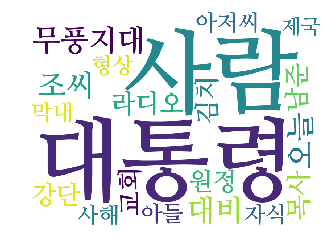

2018-03-31T00:00:00.000000000


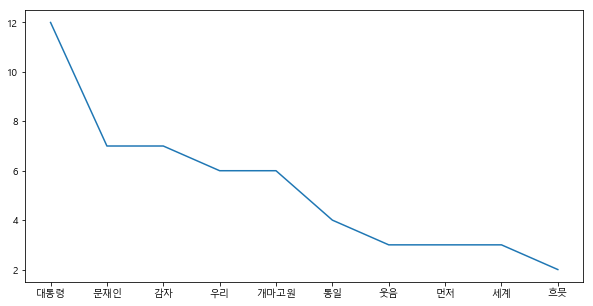

[('대통령', 12), ('문재인', 7), ('감자', 7), ('우리', 6), ('개마고원', 6), ('통일', 4), ('웃음', 3), ('먼저', 3), ('세계', 3), ('흐믓', 2), ('노무현', 2), ('소탈', 2), ('음식', 2), ('최고', 2), ('하나', 2), ('연장', 2), ('평화', 2), ('진짜', 2), ('대한민국', 2), ('기분', 2)]


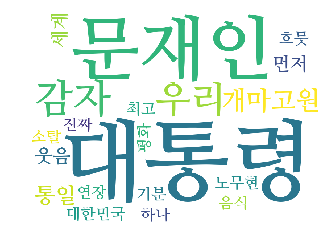

2018-04-30T00:00:00.000000000


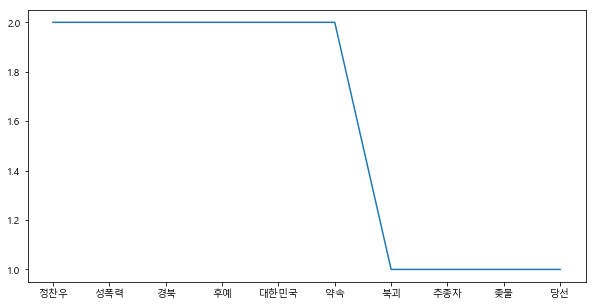

[('정찬우', 2), ('성폭력', 2), ('경북', 2), ('후예', 2), ('대한민국', 2), ('약속', 2), ('북괴', 1), ('추종자', 1), ('좆불', 1), ('당선', 1), ('개돼지', 1), ('똥령', 1), ('다지', 1), ('우리', 1), ('유머', 1), ('노통', 1), ('친구', 1), ('누리', 1), ('지원', 1), ('유세', 1)]


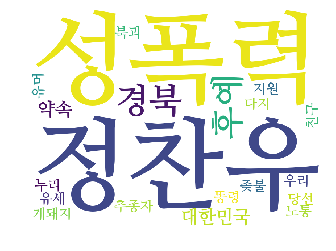

2018-05-31T00:00:00.000000000


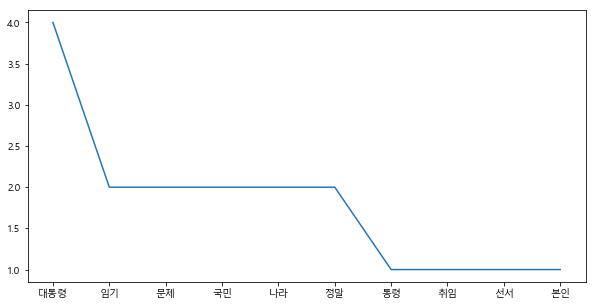

[('대통령', 4), ('임기', 2), ('문제', 2), ('국민', 2), ('나라', 2), ('정말', 2), ('통령', 1), ('취임', 1), ('선서', 1), ('본인', 1), ('공약', 1), ('분투', 1), ('평창올림픽', 1), ('외교', 1), ('갈등', 1), ('봉합', 1), ('사드', 1), ('일단락', 1), ('남북정상회담', 1), ('종전', 1)]


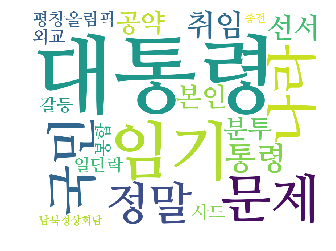

2018-06-30T00:00:00.000000000


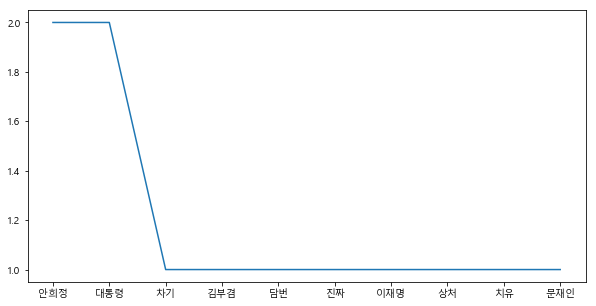

[('안희정', 2), ('대통령', 2), ('차기', 1), ('김부겸', 1), ('담번', 1), ('진짜', 1), ('이재명', 1), ('상처', 1), ('치유', 1), ('문재인', 1), ('지금', 1), ('세월', 1), ('인물', 1), ('부탁', 1), ('대통', 1)]


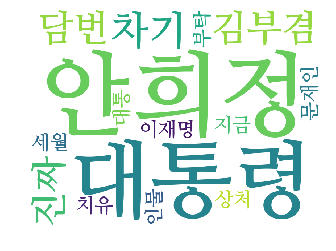

2018-07-31T00:00:00.000000000


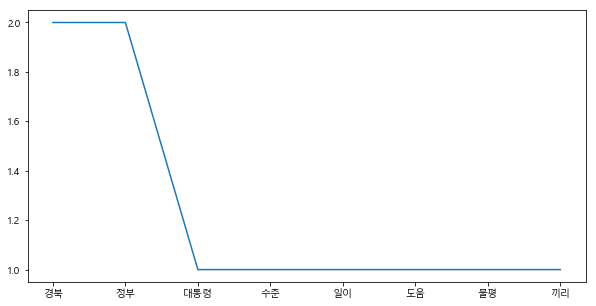

[('경북', 2), ('정부', 2), ('대통령', 1), ('수준', 1), ('일이', 1), ('도움', 1), ('불평', 1), ('끼리', 1)]


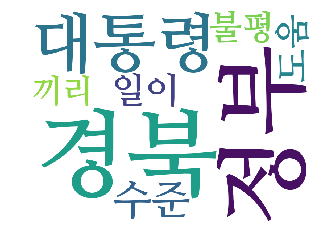

2018-08-31T00:00:00.000000000


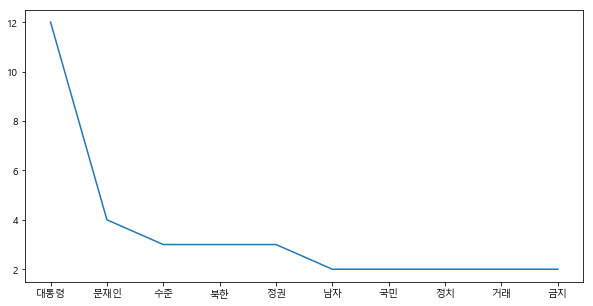

[('대통령', 12), ('문재인', 4), ('수준', 3), ('북한', 3), ('정권', 3), ('남자', 2), ('국민', 2), ('정치', 2), ('거래', 2), ('금지', 2), ('붕괴', 2), ('개헌', 2), ('가장', 1), ('얼굴', 1), ('혐오', 1), ('울화', 1), ('초이스', 1), ('재초', 1), ('이스', 1), ('우리', 1)]


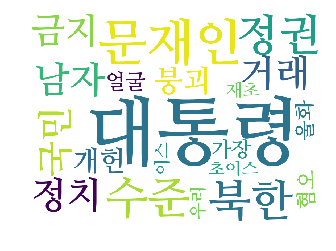

2018-09-30T00:00:00.000000000


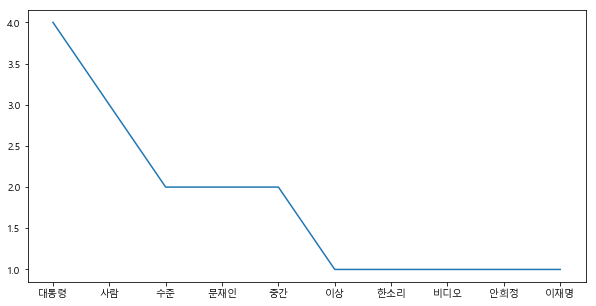

[('대통령', 4), ('사람', 3), ('수준', 2), ('문재인', 2), ('중간', 2), ('이상', 1), ('한소리', 1), ('비디오', 1), ('안희정', 1), ('이재명', 1), ('댓글', 1), ('과반수', 1), ('정치인', 1), ('정치', 1), ('인품', 1), ('명품', 1), ('항상', 1), ('응원', 1), ('지지', 1), ('당장', 1)]


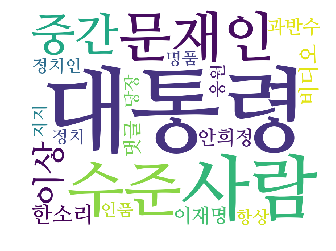

2018-10-31T00:00:00.000000000


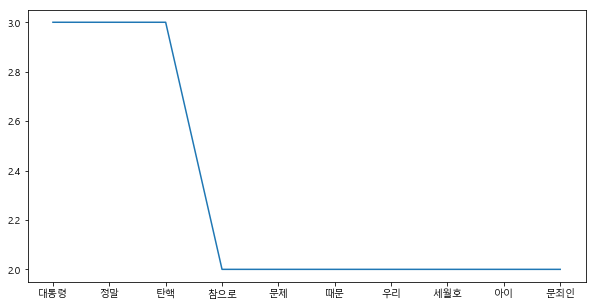

[('대통령', 3), ('정말', 3), ('탄핵', 3), ('참으로', 2), ('문제', 2), ('때문', 2), ('우리', 2), ('세월호', 2), ('아이', 2), ('문죄인', 2), ('지지자', 1), ('유승민', 1), ('후보', 1), ('다시', 1), ('취임식', 1), ('참석', 1), ('그림', 1), ('장점', 1), ('대북', 1), ('안보', 1)]


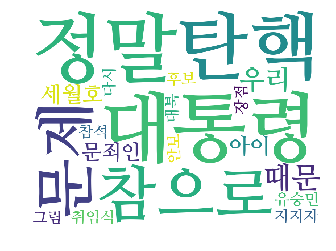

2018-11-30T00:00:00.000000000


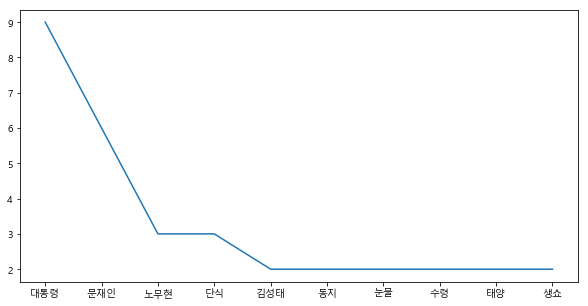

[('대통령', 9), ('문재인', 6), ('노무현', 3), ('단식', 3), ('김성태', 2), ('동지', 2), ('눈물', 2), ('수령', 2), ('태양', 2), ('생쇼', 2), ('만세', 2), ('뮤지컬', 1), ('그냥', 1), ('개판', 1), ('난생처음', 1), ('다운', 1), ('손를', 1), ('계속', 1), ('어가', 1), ('국민', 1)]


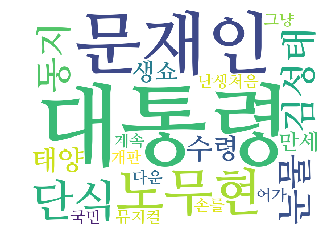

2018-12-31T00:00:00.000000000


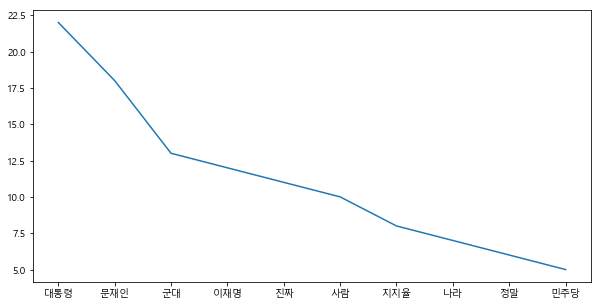

[('대통령', 22), ('문재인', 18), ('군대', 13), ('이재명', 12), ('진짜', 11), ('사람', 10), ('지지율', 8), ('나라', 7), ('정말', 6), ('민주당', 5), ('북한', 5), ('김경수', 5), ('우리', 5), ('지지', 5), ('운명', 4), ('지사', 4), ('노무현', 4), ('국가', 4), ('부대', 4), ('걱정', 3)]


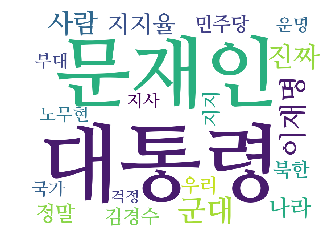

2019-01-31T00:00:00.000000000


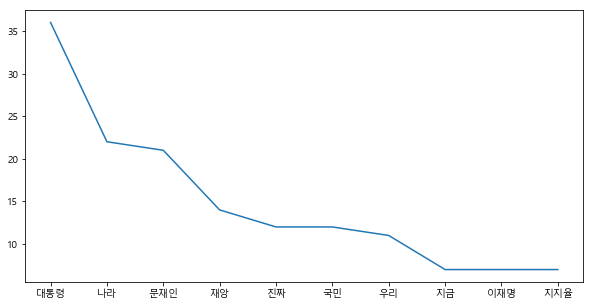

[('대통령', 36), ('나라', 22), ('문재인', 21), ('재앙', 14), ('진짜', 12), ('국민', 12), ('우리', 11), ('지금', 7), ('이재명', 7), ('지지율', 7), ('새끼', 7), ('경제', 6), ('역시', 6), ('김경수', 6), ('쓰레기', 6), ('군인', 6), ('대한민국', 6), ('사람', 6), ('군대', 5), ('정권', 5)]


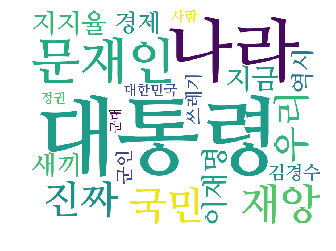

2019-02-28T00:00:00.000000000


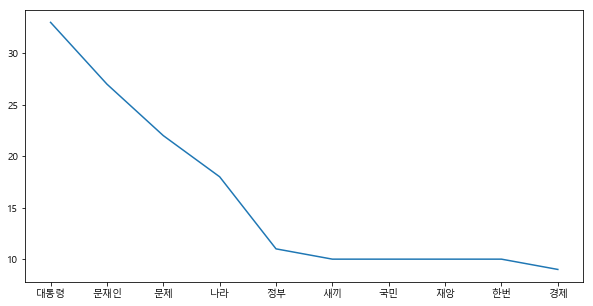

[('대통령', 33), ('문재인', 27), ('문제', 22), ('나라', 18), ('정부', 11), ('새끼', 10), ('국민', 10), ('재앙', 10), ('한번', 10), ('경제', 9), ('진짜', 9), ('북한', 9), ('국가', 8), ('존나', 7), ('개돼지', 7), ('박근혜', 7), ('지지율', 7), ('사람', 7), ('생각', 7), ('대한민국', 6)]


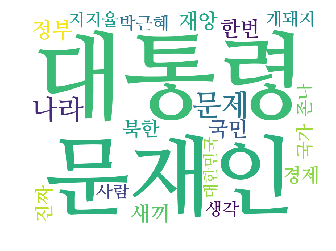

2019-03-31T00:00:00.000000000


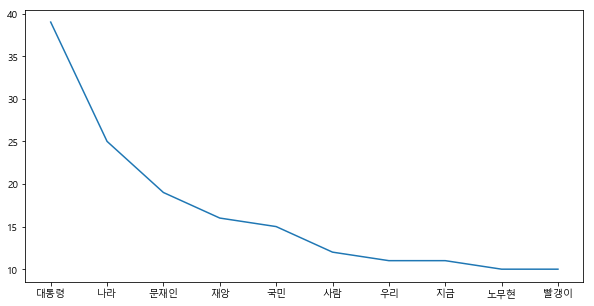

[('대통령', 39), ('나라', 25), ('문재인', 19), ('재앙', 16), ('국민', 15), ('사람', 12), ('우리', 11), ('지금', 11), ('노무현', 10), ('빨갱이', 10), ('정치', 10), ('새끼', 9), ('시작', 9), ('군대', 8), ('정권', 8), ('북한', 7), ('대한민국', 7), ('이제', 6), ('문제', 6), ('진짜', 6)]


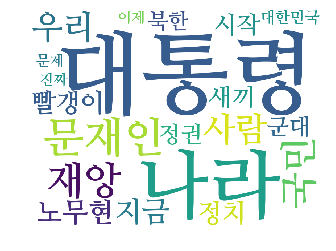

2019-04-30T00:00:00.000000000


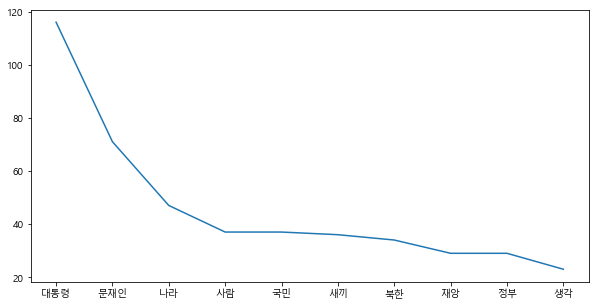

[('대통령', 116), ('문재인', 71), ('나라', 47), ('사람', 37), ('국민', 37), ('새끼', 36), ('북한', 34), ('재앙', 29), ('정부', 29), ('생각', 23), ('문제', 23), ('진짜', 23), ('경제', 22), ('지금', 20), ('빨갱이', 19), ('지지', 18), ('제발', 17), ('병신', 17), ('정책', 16), ('댓글', 16)]


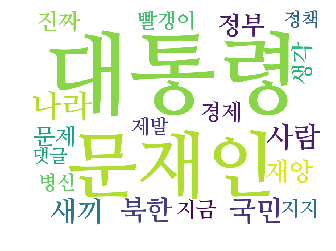

2019-05-31T00:00:00.000000000


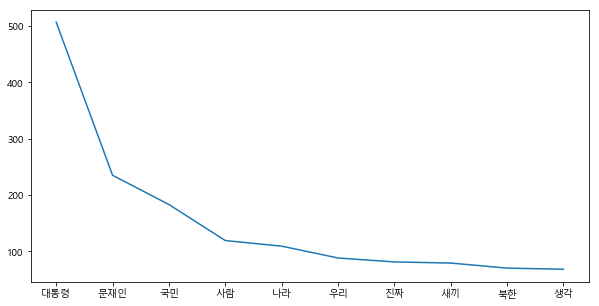

[('대통령', 507), ('문재인', 235), ('국민', 183), ('사람', 119), ('나라', 109), ('우리', 88), ('진짜', 81), ('새끼', 79), ('북한', 70), ('생각', 68), ('재앙', 63), ('사랑', 61), ('지금', 59), ('경제', 58), ('대한민국', 56), ('정말', 55), ('광주', 51), ('정부', 47), ('존경', 46), ('댓글', 42)]


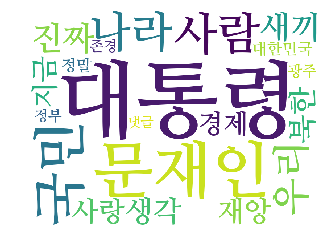

2019-06-30T00:00:00.000000000


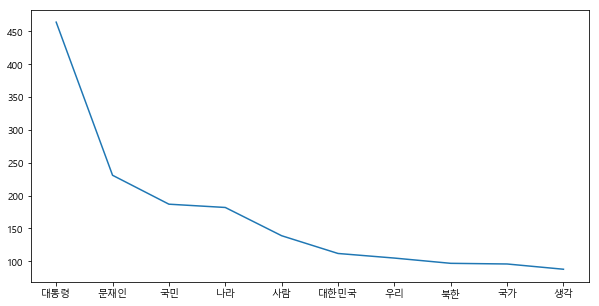

[('대통령', 464), ('문재인', 231), ('국민', 187), ('나라', 182), ('사람', 139), ('대한민국', 112), ('우리', 105), ('북한', 97), ('국가', 96), ('생각', 88), ('빨갱이', 85), ('목사', 78), ('새끼', 77), ('진짜', 69), ('한국', 69), ('응원', 68), ('자유', 68), ('사랑', 67), ('김원봉', 63), ('정치', 61)]


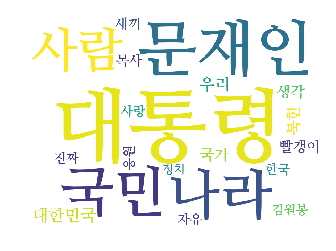

In [92]:
for i in range(len(df_time_series['title'])):
    print(df_time_series.index.values[i])
    draw_frequency(df_time_series['title'][i])
    draw_wordcloud(df_time_series['title'][i])


C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\syw51\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                                       title  \
date                                                                           
2017-03-31 00:00:00+00:00  [(안녕하다, Adjective), (dingo, Alpha), (수고, Noun)...   
2017-05-31 00:00:00+00:00  [(안, Noun), (지사, Noun), (님, Suffix), (눈물나다, Ve...   
2017-06-30 00:00:00+00:00  [(지사, Noun), (님, Suffix), (뭐, Noun), (하다, Verb...   
2017-07-31 00:00:00+00:00  [(명왕, Noun), (님, Suffix), (축하, Noun), (드리다, Ve...   
2017-08-31 00:00:00+00:00  [(허허, Adverb), (허다, Verb), (문재인, Noun), (정부, N...   
2017-09-30 00:00:00+00:00  [(문재인, Noun), (대통령, Noun), (님, Suffix), (당신, N...   
2017-10-31 00:00:00+00:00  [(귀엽다, Adjective), (ㅜㅜ, KoreanParticle), (문죄인,...   
2017-11-30 00:00:00+00:00  [(33716, Number), (가볍다, Adjective), (접촉, Noun)...   
2017-12-31 00:00:00+00:00  [(2017년, Number), (12월, Number), (01일, Number)...   
2018-01-31 00:00:00+00:00  [(이재명, Noun), (이, Josa), (답, Noun), (이다, Josa)...   
2018-02-28 00:00:00+00:00  [(무풍지대, Noun)

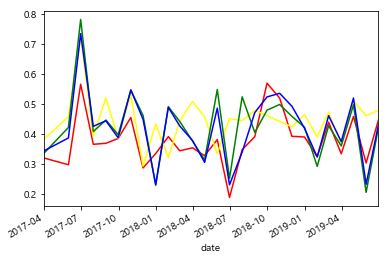

분노-빨강
기대-노랑
기쁨-초록
슬픔-파랑


In [93]:
df_sent = Analyze_sentiment(df_time_series)
draw_sent(df_sent)

# 6) 결론<br>
유튜브에서 댓글 데이터를 가져오고, 빈도수와 감정을 분석하는 것을 개발하였다. 대체적으로 관련된 키워드의 빈도수가 많아지는 것을 볼 수 있다. 또한 감정 추이 또한 사건에 따라 유동적 인것을 볼 수 있다. 대중의 감정또한 어느정도 투영함을 알 수 있다
하지만 본 탐구에서는 형태소 분석의 한계, 감정 분석 알고리즘의 한계, 유튜브 알고리즘에 종속적인 결과로 인해 결과가 깔끔하게 도출되지 않았다. 위와 같은 점을 개선하면 더욱 명확한 감정분석을 수행 할 수 있을 것이다.
# 7) 참고문헌<br>
쿠지라 히코우즈쿠에,파이썬을 이용한 머신러닝, 딥러닝 실전 개발 입문』,위키북스,2017
# 8) 별첨1: (3)의 획득한 데이터 원본<br>
000title.xlsx 파일
# 9) 별첨2: (4)의 가공된 데이터 원본<br>
000comment.xlsx 파일

